# Elliptical Slice Sampling
The purpose of this notebook is to check if the `elliptic.py` file implementing Elliptical Slice Sampling works as expected, whilst demonstrating how it can be used to sample from the latent variable posterior $p(\mathbf{f} | \mathbf{y}, \boldsymbol{\theta})$.

In [1]:
import numpy as np

from matplotlib import pyplot as plt

from gproc.elliptic_cpp import ess_samples_probit_cpp
from gproc.generative import sample_at_x
from gproc.kernels import squared_exponential
from gproc.kernels import rational_quadratic
from gproc.kernels import periodic

## Data Generation

In [2]:
N = 500 # Data size
D = 1 # Data dimension

x = np.random.uniform(-1, 1, N * D).reshape(-1, D) # Reshape to N x D matrix
#y, prob_y, f = sample_at_x(x, kernel_fcn=periodic, kernel_params = {'lengthscale': 1, 'variance': 1.4, 'period':2})
y, prob_y, f = sample_at_x(x, kernel_fcn=squared_exponential, kernel_params = {'lengthscale': 0.1, 'variance': 1.4})
y=y.astype("float64")

## Generate Latent Posterior Samples

In [3]:
model_lengthscale=0.1
model_variance=1.4
K = squared_exponential(x, x, lengthscale=model_lengthscale, variance=model_variance)
#K = rational_quadratic(x, x, lengthscale=0.1, variance=1.4, weighting=1)
#K = periodic(x, x, lengthscale=1, variance=1.4, period=2)
K_chol = np.linalg.cholesky(K + 0.0001*np.eye(K.shape[0]))
samples = ess_samples_probit_cpp(K_chol, y, 2500, 500)

100%|███████████████████████████████████████| 2999/2999 [00:57<00:00, 52.09it/s]


## Mean of Samples Against True Function and Laplace

### ESS Samples Mean

In [4]:
ess_mean = np.mean(samples, axis=0)

In [5]:
samples

array([[ 2.14659025, -0.40597185,  2.26105345, ..., -0.89100381,
         1.1581776 , -0.7168449 ],
       [ 2.21198884, -0.42897405,  2.31430333, ..., -0.90847688,
         1.1391247 , -0.71286625],
       [ 2.17242699, -0.3648217 ,  2.26782867, ..., -0.88404038,
         1.08581292, -0.69873933],
       ...,
       [ 2.25359374, -0.51508586,  2.46510414, ..., -0.99024483,
         0.99262213, -0.80401966],
       [ 1.94427477, -0.59251986,  2.14345693, ..., -0.7637247 ,
         0.82581832, -0.54159653],
       [ 2.00623914, -0.68772062,  2.16698334, ..., -0.86635889,
         0.89832186, -0.64784508]])

### Laplace Approximation

In [6]:
from gproc.laplace import laplace_approximation_probit, chol_inverse

laplace_mean, df_ll, laplace_cov, objective_history, converged = laplace_approximation_probit(y, chol_inverse(K))

In [7]:
laplace_samples = np.random.multivariate_normal(laplace_mean, laplace_cov, 2500)

## Plot Means

In [8]:
ess_mean.shape

(500,)

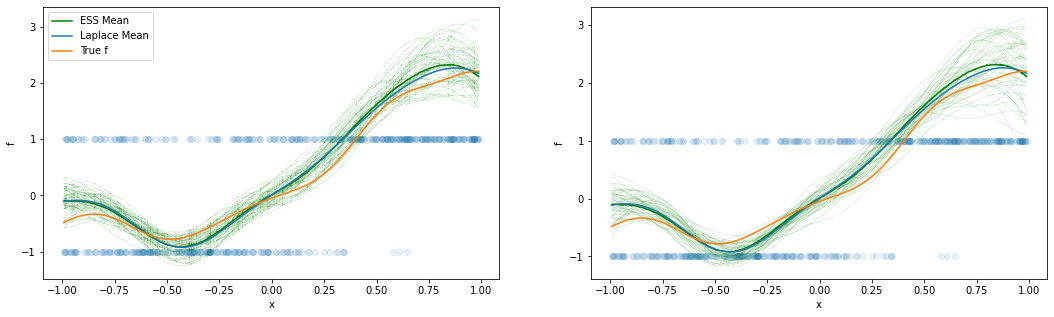

In [9]:
sort_ix = np.argsort(x.reshape(-1))

fig, axarr = plt.subplots(1, 2, figsize=(18, 5), gridspec_kw={'width_ratios': [1,1]})

axarr[0].scatter(x, y, alpha=0.1)
axarr[0].set_xlabel('x')
axarr[0].set_ylabel('f')

for i in range(0, samples.shape[0], 50):
    axarr[0].plot(x[sort_ix], samples[i, sort_ix], c = 'g', linewidth = 0.1)

axarr[0].plot(x[sort_ix], ess_mean[sort_ix], c='g', label='ESS Mean')
axarr[0].plot(x[sort_ix], laplace_mean[sort_ix], label='Laplace Mean')
axarr[0].plot(x[sort_ix], f[sort_ix], label='True f')

axarr[0].legend()

axarr[1].scatter(x, y, alpha=0.1)
axarr[1].set_xlabel('x')
axarr[1].set_ylabel('f')

for i in range(0, laplace_samples.shape[0], 50):
    axarr[1].plot(x[sort_ix], laplace_samples[i, sort_ix], c = 'g', linewidth = 0.1)

axarr[1].plot(x[sort_ix], ess_mean[sort_ix], c='g', label='ESS Mean')
axarr[1].plot(x[sort_ix], laplace_mean[sort_ix], label='Laplace Mean')
axarr[1].plot(x[sort_ix], f[sort_ix], label='True f')
axarr[0].legend()

(array([  1.,   2.,   4.,   3.,   5.,  19.,  13.,  14.,  24.,  53.,  37.,
         45.,  58.,  81.,  88., 114., 118., 121., 146., 127., 132., 105.,
        128.,  98., 120., 119., 103.,  69.,  77.,  96.,  67.,  53.,  49.,
         32.,  28.,  25.,  17.,  19.,   9.,  17.,  14.,  13.,  12.,   9.,
          8.,   0.,   5.,   2.,   0.,   1.]),
 array([1.18072828, 1.22557048, 1.27041268, 1.31525487, 1.36009707,
        1.40493927, 1.44978147, 1.49462367, 1.53946586, 1.58430806,
        1.62915026, 1.67399246, 1.71883465, 1.76367685, 1.80851905,
        1.85336125, 1.89820345, 1.94304564, 1.98788784, 2.03273004,
        2.07757224, 2.12241444, 2.16725663, 2.21209883, 2.25694103,
        2.30178323, 2.34662542, 2.39146762, 2.43630982, 2.48115202,
        2.52599422, 2.57083641, 2.61567861, 2.66052081, 2.70536301,
        2.75020521, 2.7950474 , 2.8398896 , 2.8847318 , 2.929574  ,
        2.9744162 , 3.01925839, 3.06410059, 3.10894279, 3.15378499,
        3.19862718, 3.24346938, 3.28831158, 3.

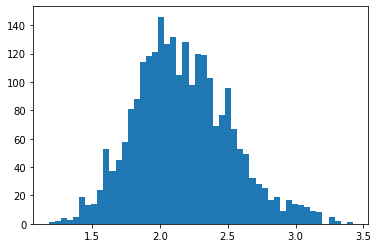

In [10]:
plt.hist(samples[:,0], bins=50)